In [119]:
import pickle
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

In [21]:
lmbda = 0.01
rnd_seed = 4312
l_n = []
for n in os.listdir("./results/ID/"):
    l_n.append(re.search(r"(\d+)", n).group())

In [22]:
l_n

['10', '20', '30', '40', '50', '5', '70', '90']

In [23]:
l_results_dir_ID = []
results_dir = './results/'
results_dir_ID = os.path.join(results_dir, "ID", f'{n}d', str(lmbda), f'seed{rnd_seed:02d}')

In [35]:
all_dirs = []
for n in l_n:
    results_dir_ID = f'./results/ID/{n}d/0.01/seed4312/'
    all_dirs.append(results_dir_ID)

In [101]:
l_all_results = []
for d in all_dirs:
    with open(os.path.join(d, 'results-ID.pkl'), "rb") as f:
        l_results = pickle.load(f)
        l_all_results.append(l_results)

In [108]:
subj

{'model': IndependentLinearLayerWithIntercept(),
 'train_batches_ID': <utils.BatchGenerator_ID at 0x2ae01fe9430>,
 'val_batches_ID': <utils.BatchGenerator_ID at 0x2ae01fe9790>,
 'val_batches_avg': <utils.BatchGenerator at 0x2ae01fe9910>,
 'train_accs': [0.48249998688697815,
  0.5049999952316284,
  0.47499996423721313,
  0.49000000953674316,
  0.5225000381469727,
  0.48750001192092896,
  0.5049999952316284,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.4925000071525574,
  0.4975000023841858,
  0.5024999976158142,
  0.5074999928474426,
  0.5249999761581421,
  0.5074999928474426,
  0.512499988079071,
  0.5199999809265137,
  0.5149999856948853,
  0.5174999833106995,
  0.5399999618530273,
  0.5450000166893005,
  0.5349999666213989,
  0.5525000095367432,
  0.5375000238418579,
  0.5399999618530273,
  0.5174999833106995,
  0.5399999618530273,
  0.5424999594688416,
  0.5324999690055847,
  0.5299999713897705,
  0.5199999809265137,
  0.5324999690055847,
  0.540000021457

In [113]:
l_eval = []
l_train = []
for id, all_results in enumerate(l_all_results):
    val_acc_avg = np.array([l[1] for l in all_results["l_val_avg"]])
    val_acc_ID = np.array([l[1] for l in all_results["l_val_ID"]])
    n_dim = all_results["l_train_ID"][0]["ics"].shape[0]
    l_n_data = []
    for subj in all_results["l_train_ID"]:
        train_accs = np.array(subj["train_accs"])
        df_train = pd.DataFrame({
            "ID": np.arange(0, train_accs.shape[0]),  
            "n_dim": np.repeat(n_dim, train_accs.shape[0]), 
            "epoch": np.arange(0, train_accs.shape[0]),
            "train_acc": train_accs
        })
        l_train.append(df_train)
        l_n_data.append(subj["n_choices_train"])
    n_data_train = np.array(l_n_data)
    df_eval = pd.DataFrame({
        "ID": np.arange(0, val_acc_avg.shape[0]),  
        "n_dim": np.repeat(n_dim, val_acc_avg.shape[0]), 
        "val_acc_avg": val_acc_avg, "val_acc_ID": val_acc_ID,
        "n_data_train": n_data_train
    })
    l_eval.append(df_eval)

In [114]:
dfs_eval = reduce(lambda left, right: pd.concat([left, right]), l_eval)
dfs_train = reduce(lambda left, right: pd.concat([left, right]), l_train)

In [123]:
dfs_eval["delta"] = dfs_eval["val_acc_ID"] - dfs_eval["val_acc_avg"]
dfs_eval.head()

,ID,n_dim,val_acc_avg,val_acc_ID,n_data_train,delta
0,0,10,0.582857,0.592857,2848,0.010
1,1,10,0.555000,0.535000,960,-0.020
2,2,10,0.570000,0.600000,448,0.030
3,3,10,0.585000,0.570000,928,-0.015
4,4,10,0.580000,0.560000,672,-0.020


In [126]:
dfs_eval = dfs_eval.query("n_dim <= 50")

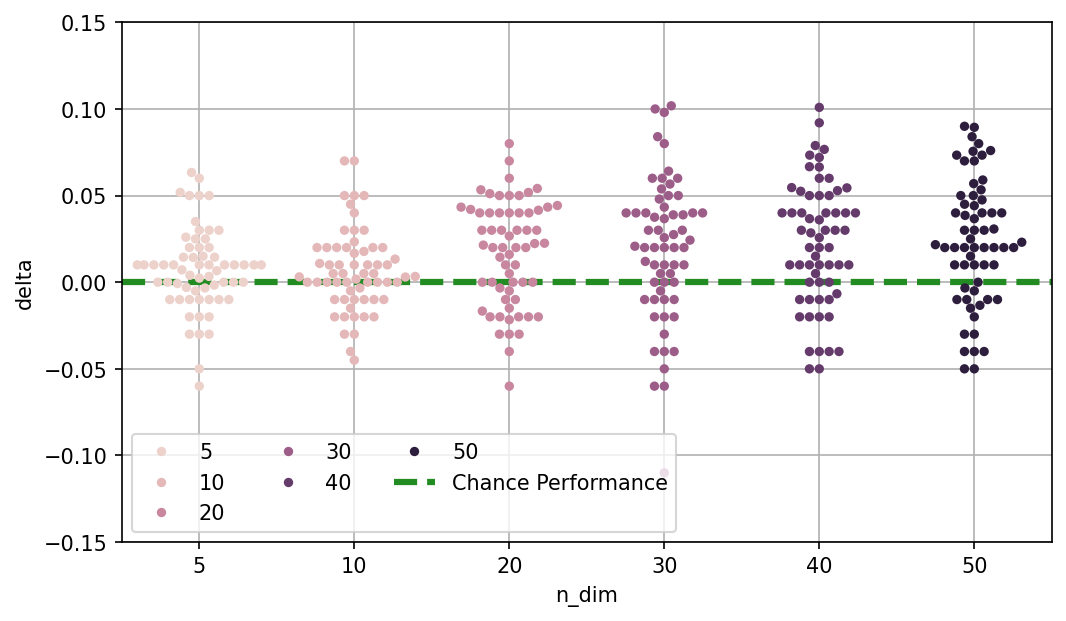

In [183]:
fig = plt.figure(figsize=(8, 4.5), dpi=150)
ax = plt.subplot(111)
sns.swarmplot(
    x="n_dim", y="delta", hue="n_dim", data=dfs_eval.reset_index(drop=True), 
    size=4.5
)
ax.axhline(y=0, color='forestgreen', linestyle='--', linewidth=3, label='Chance Performance')
ax.set_ylim(-.15, .15)
ax.legend(loc=0, ncol = 3)
ax.grid(True)

In [173]:
dfs_eval.loc[:, "n_data_train_log"] = np.log(dfs_eval["n_data_train"])

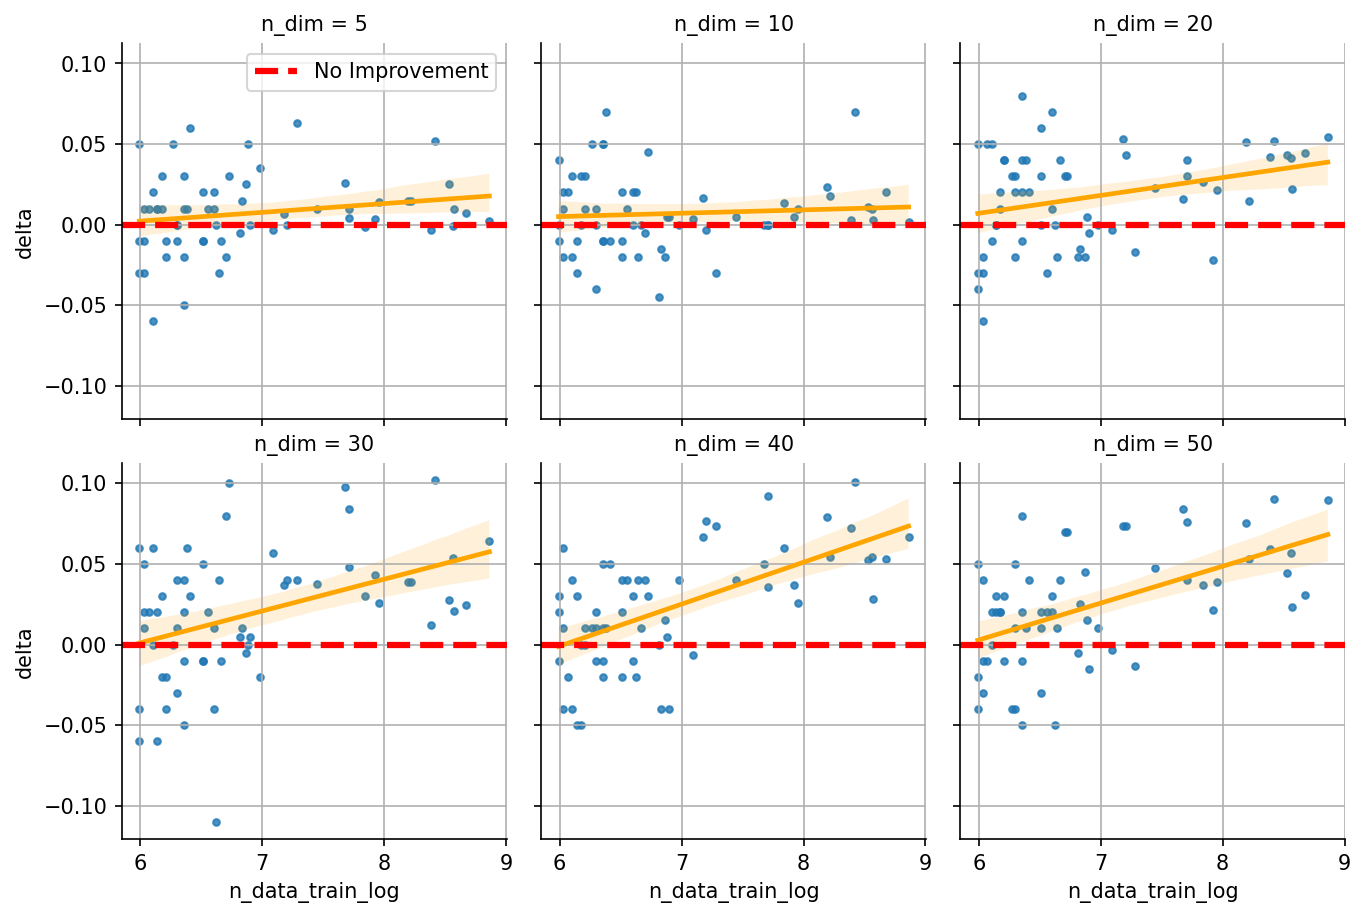

In [178]:

# Create the FacetGrid without specifying an external axis
g = sns.lmplot( data=dfs_eval, x='n_data_train_log', y='delta', col='n_dim', col_wrap=3, height=4, 
               # Adjust height for each facet 
               aspect=1, # Adjust aspect ratio 
               scatter_kws={'s': 10}, # Adjust the scatter plot marker size 
               line_kws={'color': 'orange'} # Adjust the regression line color 
              )
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=3, label='No Improvement')
    if i == 0:
        ax.legend()
    
# Adjust the plot size
g.fig.set_size_inches(9, 6)
g.fig.set_dpi(150)

plt.show()
